# Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import AUTOTUNE
from tqdm import tqdm
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

2022-04-12 00:38:10.723597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Flatten, Dropout

In [3]:
ROUND = 1
EXERCISE = 'half-burpee'
CUR_CLASS = 'out'
PREV_CLASS = 'in'
SUBFIX_VID_NAME = '_hard_vote'
REMOTE = True

# Load file paths

In [4]:
SEQ_LEN = 8
all_file_paths = []
if REMOTE:
    walk_path = f'/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_{SEQ_LEN}/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\videos\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in os.walk(walk_path):
    for name in files:
        if name.endswith('.npy'):
            all_file_paths.append(os.path.join(path, name))

In [5]:
all_file_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1057/others_1057.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/809/others_809.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1025/others_1025.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/937/others_937.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/517/others_517.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/240/others_240.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1443/others_1443.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/760/others_760.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/143/others_143.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1153/others_1153.npy',
 '/home/u6188041/jom/Dataset/EzF

In [6]:
len(all_file_paths)

5300

In [7]:
# use for stratify and check balance
labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
labels

['others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',

In [8]:
# check balanceness
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'others': 1500, 'half-burpee-in': 1491, 'half-burpee-out': 2309}),
 5300)

In [9]:
def load_numpy(path):
    return np.load(path.numpy())

In [10]:
def load_data(file_path):
    # load numpy, file_path is Tensor with dtype string
    # and np.load not working with Tensor, so we need to work around with pure tf ops
    # this function return a list with elements following Tout, 
    # so we need to access first item
    data = tf.py_function(load_numpy, inp=[file_path], Tout=[tf.float32])[0] # return as tensor with dtype tf.float32
    data = data / 255.0
    
    # get label
    label_str = tf.strings.split(file_path, os.path.sep)[-3]
    one_hot = label_str == le.classes_ # get tensor with dtype bool
    label = tf.cast(one_hot, tf.int32)
    return data, label

# Preprocess

In [11]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['half-burpee-in', 'half-burpee-out', 'others'], dtype='<U15')

In [12]:
labels = le.transform(labels)
labels

array([2, 2, 2, ..., 1, 1, 1])

In [13]:
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)

In [14]:
len(train_paths), len(test_paths)

(4770, 530)

# Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [15]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [16]:
class_weights

{2: 1.1777777777777778, 0: 1.184887100380058, 1: 0.7651219864299119}

# Build data pipeline

In [17]:
# define hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

2022-04-12 00:38:11.930771: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-12 00:38:11.953554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 00:38:11.954081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-12 00:38:11.954098: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-12 00:38:11.955548: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-12 00:38:11.955576: I tensorflow/stream_executor/plat

In [19]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [20]:
# check the shape and dtype
next(iter(train_ds))

2022-04-12 00:38:12.452715: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 00:38:12.453770: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499880000 Hz
2022-04-12 00:38:12.531735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 8, 120, 120, 3), dtype=float32, numpy=
 array([[[[[1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
 
          [[1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
 
          [[1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],


# Model training

In [21]:
tf.keras.backend.clear_session()

In [22]:
# define callback (tensorboard)
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

2022-04-12 00:38:12.585870: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 00:38:12.585887: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-12 00:38:12.585913: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-04-12 00:38:12.586174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64
2022-04-12 00:38:12.586553: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-04-12 00:38:12.665705: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 00:38:12.665831: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


In [23]:
# change to CNN
model = tf.keras.Sequential([
    InputLayer(input_shape=(SEQ_LEN,120,120,3), dtype=tf.dtypes.float32),
    TimeDistributed(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')),
    TimeDistributed(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')),
    TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')),
    TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    TimeDistributed(Dropout(0.25)),
    TimeDistributed(Flatten()),
    # ลด lstm เหลืออันเดียวได้ เหลือ unit สัก 64
#     LSTM(128, return_sequences=True, activation='relu'),
#     LSTM(128, return_sequences=True, activation='relu'),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 8, 120, 120, 16)   448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 120, 120, 16)   2320      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 8, 60, 60, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 8, 60, 60, 32)     4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 8, 60, 60, 32)     9248      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 8, 30, 30, 32)     0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 8, 30, 30, 64)     1

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [26]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2022-04-12 00:38:13.750005: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-12 00:38:14.168787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-04-12 00:38:14.584494: W tensorflow/stream_executor/gpu/asm_compiler.cc:99] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-04-12 00:38:14.585545: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.5
2022-04-12 00:38:14.585565: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2022-04-12 00:38:14.585639: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Fallin

  1/150 [..............................] - ETA: 8:31 - loss: 1.1094 - accuracy: 0.3125

2022-04-12 00:38:16.350970: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 00:38:16.350993: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/150 [..............................] - ETA: 1:03 - loss: 1.6048 - accuracy: 0.2656

2022-04-12 00:38:16.741386: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-12 00:38:16.742038: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-04-12 00:38:16.775007: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 816 callback api events and 813 activity events. 
2022-04-12 00:38:16.789799: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 00:38:16.807242: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_04_12_00_38_16
2022-04-12 00:38:16.823344: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_04_12_00_38_16/jarvis.trace.json.gz
2022-04-12 00:38:16.855014: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

150/150 [==============================] - 17s 92ms/step - loss: 1.1036 - accuracy: 0.3333 - val_loss: 1.0973 - val_accuracy: 0.4358
Epoch 2/150
150/150 [==============================] - 12s 78ms/step - loss: 1.0987 - accuracy: 0.3419 - val_loss: 1.0970 - val_accuracy: 0.3340
Epoch 3/150
150/150 [==============================] - 12s 78ms/step - loss: 1.0438 - accuracy: 0.4317 - val_loss: 0.8859 - val_accuracy: 0.5264
Epoch 4/150
150/150 [==============================] - 12s 77ms/step - loss: 0.7035 - accuracy: 0.6172 - val_loss: 0.4977 - val_accuracy: 0.7585
Epoch 5/150
150/150 [==============================] - 12s 77ms/step - loss: 0.4626 - accuracy: 0.7472 - val_loss: 0.4021 - val_accuracy: 0.7755
Epoch 6/150
150/150 [==============================] - 12s 78ms/step - loss: 0.3556 - accuracy: 0.8086 - val_loss: 0.3477 - val_accuracy: 0.8415
Epoch 7/150
150/150 [==============================] - 12s 78ms/step - loss: 0.2693 - accuracy: 0.8616 - val_loss: 0.2632 - val_accuracy: 0.90

# Setup all dirs

In [28]:
import os

In [29]:
all_dirs = []
model_dir = f'saved_models/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [30]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [31]:
model.save(f'saved_models/round_{ROUND}/{EXERCISE}/{EXERCISE}_video_sequence.h5', save_format='h5')

In [32]:
# serialize lb
with open(f'saved_pickles/round_{ROUND}/{EXERCISE}/{EXERCISE}_video_sequence_le.pickle', 'wb') as file:
    pickle.dump(le, file)

## Convert model to tfjs model

In [33]:
loaded_model = tf.keras.models.load_model(f'saved_models/round_{ROUND}/{EXERCISE}/{EXERCISE}_video_sequence.h5')

In [34]:
loaded_model.inputs

[<KerasTensor: shape=(None, 8, 120, 120, 3) dtype=float32 (created by layer 'input_1')>]

In [35]:
loaded_model.outputs

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense')>]

In [36]:
# tfjs.converters.save_keras_model(loaded_model, 'models/tfjs_models/RepCount_Pushup')

# Evaluation

In [37]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,

In [38]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,

In [39]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [40]:
# better result with weight decay and patience = 7
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

17/17 [==============================] - 0s 21ms/step - loss: 0.0184 - accuracy: 0.9906
Test accuracy: 0.9905660152435303


### Confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [42]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

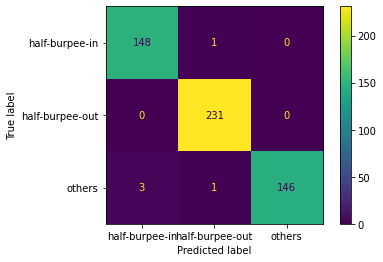

In [43]:
disp.plot()
plt.savefig(f'saved_artifacts/conf_matrix/final/{EXERCISE}/vid_seq_cm.png', dpi=300)
plt.show()

### ROC AUC

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(raw_test_y, raw_preds_y)

0.999964817096556

# Make detection with model

In [46]:
# serialize model and le
with open(f'saved_pickles/round_{ROUND}/{EXERCISE}/{EXERCISE}_video_sequence_le.pickle', 'rb') as file:
    loaded_le = pickle.load(file)

In [47]:
from collections import deque

In [48]:
NUM_TEST_VIDS = 3
SEQ_LEN = 8
for i in range(1,1+NUM_TEST_VIDS):
    vid_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    rep_count = 0
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)
    video_writer = cv2.VideoWriter(f'output_videos/round_{ROUND}/{EXERCISE}/{EXERCISE}_{i}_vid_seq{SUBFIX_VID_NAME}.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        
        image = cv2.resize(frame, (640, 360))
            
        image_input = cv2.resize(frame, (120, 120))

        vid_seq.append(image_input)

        if len(vid_seq) == SEQ_LEN:
            input_seq = np.array(vid_seq) / 255.0
            y_hat = loaded_model.predict(tf.expand_dims(input_seq, axis=0))[0]
            y_idx = np.argmax(y_hat)
            
            if 'hard_vote' in SUBFIX_VID_NAME:
                # do hard voting
                preds_window.append(y_idx)
                pred_count = Counter(preds_window)
                # most_common return .items() format
                # ex. [(0,5), (1,3)]
                voted_pred = pred_count.most_common(1)[0][0]
                class_name = loaded_le.classes_[voted_pred]
            else:
                class_name = loaded_le.classes_[y_idx]
            
            prob = np.max(y_hat)
            print(y_hat, class_name, prob, end='\r')
        else:
            class_name = "None"
            prob = 0

        # count the rep logic
        current_stage = class_name

        if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
            rep_count += 1

        previous_stage = current_stage

        print('rep:',rep_count, end='\r')

        # status box at top left corner
        cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

        # display class
        cv2.putText(image, 'Class', (95, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, class_name, (95, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # display prob
        cv2.putText(image, 'Prob', (15, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # rep count box at top right corner
        cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

        # display rep count
        cv2.putText(image, 'Rep', (640-52, 0+15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(rep_count), (640-52, 0+50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

        video_writer.write(image)
        if not REMOTE:
            cv2.imshow('Squat Count Detection', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    video_writer.release()
    if not REMOTE:
        cv2.destroyAllWindows()

# Save class for visualization
only the best performing model

In [49]:
NUM_TEST_VIDS = 3
SEQ_LEN = 8
for i in range(1, 1+NUM_TEST_VIDS):
    vid_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    predicted_class = []
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_size = (640, 360)
        
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        image = cv2.resize(image, (640, 360))
                
        image_input = cv2.resize(frame, (120, 120))

        vid_seq.append(image_input)
        
        if len(vid_seq) == SEQ_LEN:
            input_seq = np.array(vid_seq) / 255.0
            y_hat = loaded_model.predict(tf.expand_dims(input_seq, axis=0))[0]
            y_idx = np.argmax(y_hat)
            
            if 'hard_vote' in SUBFIX_VID_NAME:
                # do hard voting
                preds_window.append(y_idx)
                pred_count = Counter(preds_window)
                # most_common return .items() format
                # ex. [(0,5), (1,3)]
                voted_pred = pred_count.most_common(1)[0][0]
                class_name = loaded_le.classes_[voted_pred]
                predicted_class.append(voted_pred)
            else:
                class_name = loaded_le.classes_[y_idx]
                predicted_class.append(y_idx)
            
            prob = np.max(y_hat)
            print(y_hat, class_name, prob, end='\r')
        else:
            predicted_class.append(0)
            class_name = "None"
            prob = 0

        # status box at top left corner
        cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

        # display class
        cv2.putText(image, 'Class', (95, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, class_name, (95, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # display prob
        cv2.putText(image, 'Prob', (15, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # rep count box at top right corner
        cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)
            
        if not REMOTE:
            cv2.imshow('Squat Count Detection', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
            
    temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/round_{ROUND}'
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path, exist_ok=True)
    with open(os.path.join(temp_save_path, f'test_vid_{i}_vid_seq{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
        pickle.dump(predicted_class, f)
    cap.release()
    if not REMOTE:
        cv2.destroyAllWindows()